In [2]:
import os
import sys
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split

import sys
sys.path.append(os.path.abspath(os.path.join('..')))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from src.models.dl_models import MLPModel,LSTMModel,CNNModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Evaluación del conjunto de pruebas

In [2]:
project_root = os.path.dirname(os.getcwd())
models_path = os.path.join(project_root,'models')

results_path = models_path +'/results'

In [3]:
df_cv_temp = pd.read_csv(results_path+ '/resultados_cv_temporales.csv')
df_cv_spec = pd.read_csv(results_path+ '/resultados_cv_espectrales.csv')

In [4]:
df_cv_temp.iloc[:, :-1]

,Modelo,F1-score,Balanced accuracy,Accuracy,ROC-AUC,Tiempo promedio (s)
0,RandomForest,0.957805,0.938620,0.958473,0.996335,4.600610
1,KNN,0.912630,0.838632,0.914833,0.971831,0.096633
2,SVM,0.869028,0.799470,0.878479,0.976068,8.951016
3,MLP,0.879070,0.813077,0.885691,0.979457,2.031720
4,LSTM,0.884806,0.832654,0.891010,0.981826,2.542023
5,CNN,0.896776,0.859309,0.892834,0.987722,2.628850


In [5]:
df_cv_spec.iloc[:, :-1]

,Modelo,F1-score,Balanced accuracy,Accuracy,ROC-AUC,Tiempo promedio (s)
0,RandomForest,0.925543,0.887297,0.928895,0.993026,19.577877
1,KNN,0.834900,0.787608,0.841469,0.936100,0.194796
2,SVM,0.684738,0.611657,0.756229,0.912460,34.507296
3,MLP,0.864835,0.804147,0.873962,0.975403,1.922162
4,LSTM,0.544668,0.429321,0.600685,0.815954,2.485011
5,CNN,0.873910,0.872244,0.870031,0.988751,2.736340


In [6]:
df_test_temp = pd.read_csv(results_path+ '/resultados_test_temporales.csv')
df_test_spec = pd.read_csv(results_path+ '/resultados_test_espectrales.csv')

In [7]:
df_test_temp

,Modelo,F1-score,Balanced accuracy,Accuracy,ROC-AUC,Tiempo entrenamiento (s),Tiempo predicción (s),Tiempo total (s),Archivo
0,RandomForest,0.963173,0.946175,0.963578,0.997994,5.531208,0.085143,5.620663,randomforest_features_temporales.pkl
1,KNN,0.916651,0.844049,0.918415,0.979803,0.001949,0.136626,0.142704,knn_features_temporales.pkl
2,SVM,0.875643,0.813263,0.883159,0.975860,10.509158,1.559111,12.073963,svm_features_temporales.pkl
3,MLP,0.890581,0.834659,0.894231,0.980625,2.252983,0.028854,2.281837,mlp_features_temporales.pth
4,LSTM,0.890759,0.843883,0.896270,0.982872,2.817731,0.032773,2.850504,lstm_features_temporales.pth
5,CNN,0.909892,0.872157,0.907634,0.992332,2.947920,0.052356,3.000277,cnn_features_temporales.pth


In [8]:
df_test_spec

,Modelo,F1-score,Balanced accuracy,Accuracy,ROC-AUC,Tiempo entrenamiento (s),Tiempo predicción (s),Tiempo total (s),Archivo
0,RandomForest,0.927529,0.893539,0.930653,0.994049,23.467610,0.101478,23.573536,randomforest_features_espectrales.pkl
1,KNN,0.846163,0.808344,0.851690,0.941490,0.012187,0.319059,0.335637,knn_features_espectrales.pkl
2,SVM,0.679534,0.606782,0.753788,0.918519,45.482007,7.147508,52.635130,svm_features_espectrales.pkl
3,MLP,0.875516,0.812003,0.881702,0.978459,2.478218,0.030478,2.508696,mlp_features_espectrales.pth
4,LSTM,0.558832,0.448121,0.619464,0.829189,2.942172,0.033652,2.975824,lstm_features_espectrales.pth
5,CNN,0.794739,0.745562,0.773893,0.983107,3.353151,0.039967,3.393118,cnn_features_espectrales.pth


## Análisis de confusiones frecuentes entre clases y visualización de ejemplos clasificados correctamente e incorrectamente

- y_temp_test: etiquetas verdaderas
- y_temp_pred: predicciones del modelo
- X_temp_test: features del test

In [3]:
project_root = os.path.dirname(os.getcwd())
data_path = os.path.join(project_root, 'data')
processed_path = data_path + '/processed'

save_models_path = os.path.join(project_root, 'models', 'save_models')
save_results_path = os.path.join(project_root, 'models', 'results')

features_temporal = pd.read_csv(processed_path + '/features_temporales_labelNum_overlap50.csv')
features_espectrales = pd.read_csv(processed_path + '/features_espectrales_labelNum_overlap50.csv')

X_temp = features_temporal.iloc[:, 1:-1] 
y_temp = features_temporal.iloc[:, -1]  
X_spec = features_espectrales.iloc[:, 1:-1] 
y_spec = features_espectrales.iloc[:, -1]  

# Dividir el dataset en entrenamiento y prueba
X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
X_spec_train, X_spec_test, y_spec_train, y_spec_test = train_test_split(X_spec, y_spec, test_size=0.2, random_state=42)

In [6]:
def confusion_matrix_models(y_test, y_pred, title):
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(title)
    plt.show

In [11]:
def ejemplos_clasificados(y_type_test, y_type_pred, type, model):
    print(f'Ejemplos clasificados de {model} - {type}',)
    correct_idx_type = np.where(y_type_test == y_type_pred)[0]
    incorrect_idx_type = np.where(y_type_test != y_type_pred)[0]
    
    print("\nClasificados correctamente:")
    display(pd.DataFrame({
        'Index': y_type_test.index[correct_idx_type],
        'True': y_type_test.values[correct_idx_type],
        'Pred': y_type_pred[correct_idx_type]
    }).head(5))

    print("\nClasificados incorrectamente:")
    display(pd.DataFrame({
        'Index': y_type_test.index[incorrect_idx_type],
        'True': y_type_test.values[incorrect_idx_type],
        'Pred': y_type_pred[incorrect_idx_type]
    }).head(5))


### Random forest

In [4]:
rf_temp = joblib.load(save_models_path + '/randomforest_features_temporales.pkl')
rf_spec = joblib.load(save_models_path + '/randomforest_features_espectrales.pkl')

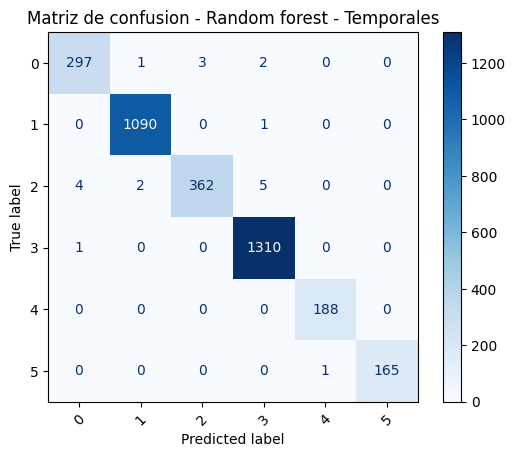

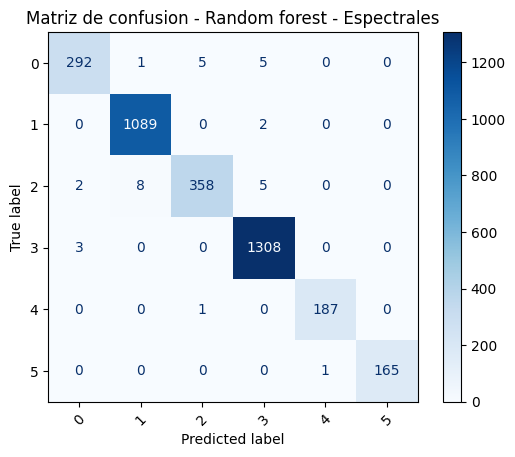

In [7]:
y_temp_pred = rf_temp.predict(X_temp_test)
y_spec_pred = rf_spec.predict(X_spec_test)

confusion_matrix_models(y_temp_test, y_temp_pred, "Matriz de confusion - Random forest - Temporales")
confusion_matrix_models(y_spec_test, y_spec_pred, "Matriz de confusion - Random forest - Espectrales")

In [9]:
confusion_matrix(y_spec_test, y_spec_pred)

array([[ 292,    1,    5,    5,    0,    0],
       [   0, 1089,    0,    2,    0,    0],
       [   2,    8,  358,    5,    0,    0],
       [   3,    0,    0, 1308,    0,    0],
       [   0,    0,    1,    0,  187,    0],
       [   0,    0,    0,    0,    1,  165]])

In [14]:
ejemplos_clasificados(y_temp_test, y_temp_pred, "temporales", "Random forest")
ejemplos_clasificados(y_spec_test, y_spec_pred, "espectrales", "Random forest")

Ejemplos clasificados de Random forest - temporales

Clasificados correctamente:


,Index,True,Pred
0,13170,1,1
1,2751,2,2
2,744,3,3
3,12907,3,3
4,15729,3,3



Clasificados incorrectamente:


,Index,True,Pred
0,13053,0,2
1,3860,0,1
2,2480,0,3
3,2281,3,0
4,11914,2,0


Ejemplos clasificados de Random forest - espectrales

Clasificados correctamente:


,Index,True,Pred
0,13170,1,1
1,2751,2,2
2,744,3,3
3,12907,3,3
4,15729,3,3



Clasificados incorrectamente:


,Index,True,Pred
0,12189,0,2
1,5380,0,2
2,16656,0,3
3,3704,3,0
4,15064,2,3


### KNN

In [15]:
knn_temp = joblib.load(save_models_path + '/knn_features_temporales.pkl')
knn_spec = joblib.load(save_models_path + '/knn_features_espectrales.pkl')

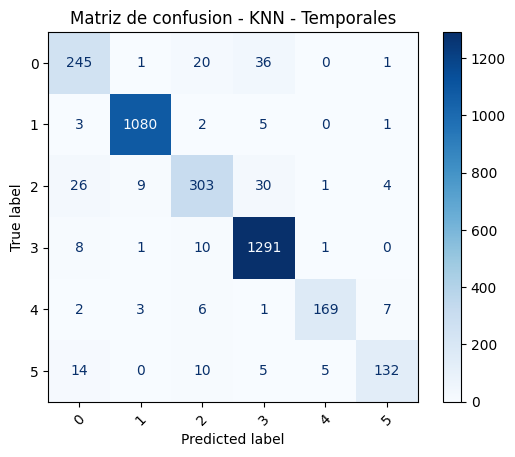

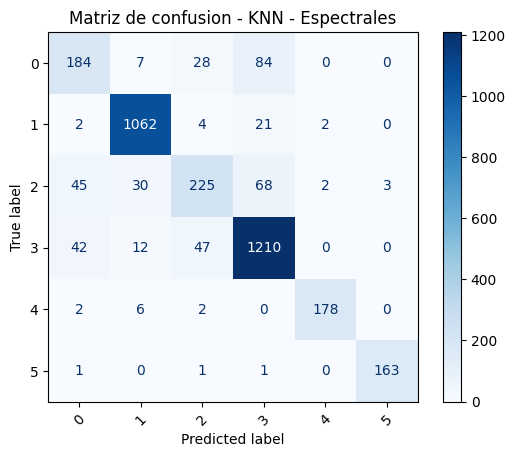

In [16]:
y_temp_pred = knn_temp.predict(X_temp_test)
y_spec_pred = knn_spec.predict(X_spec_test)

confusion_matrix_models(y_temp_test, y_temp_pred, "Matriz de confusion - KNN - Temporales")
confusion_matrix_models(y_spec_test, y_spec_pred, "Matriz de confusion - KNN - Espectrales")

In [17]:
ejemplos_clasificados(y_temp_test, y_temp_pred, "temporales", "KNN")
ejemplos_clasificados(y_spec_test, y_spec_pred, "espectrales", "KNN")

Ejemplos clasificados de KNN - temporales

Clasificados correctamente:


,Index,True,Pred
0,13170,1,1
1,2751,2,2
2,744,3,3
3,12907,3,3
4,15729,3,3



Clasificados incorrectamente:


,Index,True,Pred
0,4058,5,2
1,9180,4,5
2,12189,0,3
3,4351,0,2
4,7346,1,2


Ejemplos clasificados de KNN - espectrales

Clasificados correctamente:


,Index,True,Pred
0,13170,1,1
1,2751,2,2
2,12907,3,3
3,15729,3,3
4,8620,3,3



Clasificados incorrectamente:


,Index,True,Pred
0,744,3,2
1,9180,4,2
2,4110,2,0
3,4351,0,3
4,5665,2,0


### SVM

In [18]:
svm_temp = joblib.load(save_models_path + '/svm_features_temporales.pkl')
svm_spec = joblib.load(save_models_path + '/svm_features_espectrales.pkl')

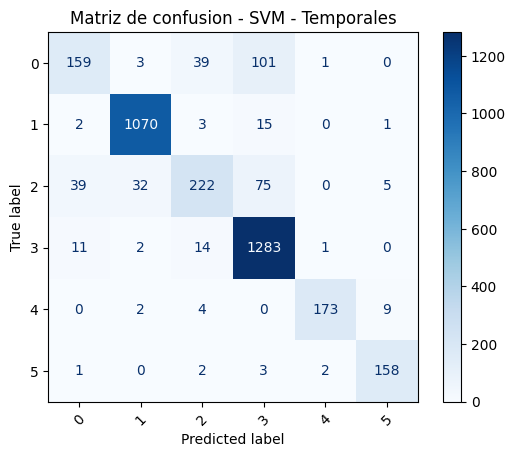

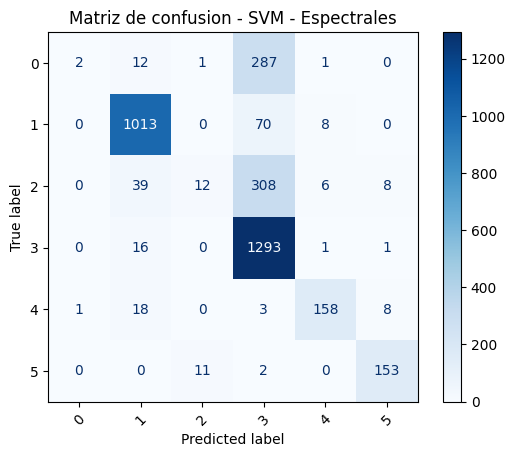

In [19]:
y_temp_pred = svm_temp.predict(X_temp_test)
y_spec_pred = svm_spec.predict(X_spec_test)

confusion_matrix_models(y_temp_test, y_temp_pred, "Matriz de confusion - SVM - Temporales")
confusion_matrix_models(y_spec_test, y_spec_pred, "Matriz de confusion - SVM - Espectrales")

In [20]:
ejemplos_clasificados(y_temp_test, y_temp_pred, "temporales", "SVM")
ejemplos_clasificados(y_spec_test, y_spec_pred, "espectrales", "SVM")

Ejemplos clasificados de SVM - temporales

Clasificados correctamente:


,Index,True,Pred
0,13170,1,1
1,12907,3,3
2,15729,3,3
3,8620,3,3
4,4058,5,5



Clasificados incorrectamente:


,Index,True,Pred
0,2751,2,3
1,744,3,2
2,9180,4,5
3,4351,0,2
4,16671,0,2


Ejemplos clasificados de SVM - espectrales

Clasificados correctamente:


,Index,True,Pred
0,13170,1,1
1,744,3,3
2,12907,3,3
3,15729,3,3
4,8620,3,3



Clasificados incorrectamente:


,Index,True,Pred
0,2751,2,3
1,9180,4,5
2,5267,3,1
3,5377,0,3
4,12189,0,3


### MLP

In [21]:
mlp_temp = MLPModel(input_size=X_temp_train.shape[1], num_classes=6).to(device)
mlp_spec = MLPModel(input_size=X_spec_train.shape[1], num_classes=6).to(device)

In [22]:
mlp_temp.load_state_dict(torch.load(save_models_path+'/mlp_features_temporales.pth', map_location='cpu'))
mlp_temp.eval()

with torch.no_grad():
    X_tensor = torch.FloatTensor(X_temp_test.values)
    outputs = mlp_temp(X_tensor)
    y_temp_pred = outputs.argmax(dim=1).numpy()
    
    
mlp_spec.load_state_dict(torch.load(save_models_path+'/mlp_features_espectrales.pth', map_location='cpu'))
mlp_spec.eval()

with torch.no_grad():
    X_tensor = torch.FloatTensor(X_spec_test.values)
    outputs = mlp_spec(X_tensor)
    y_spec_pred = outputs.argmax(dim=1).numpy()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

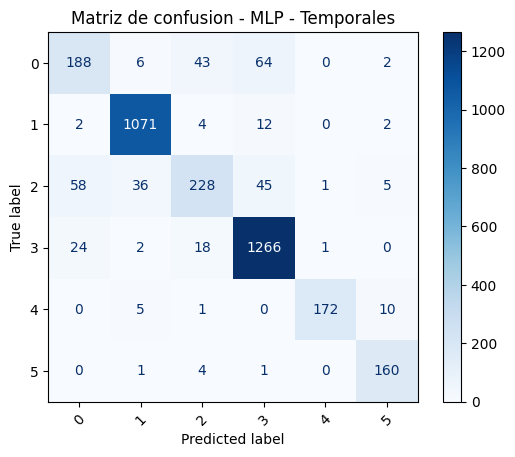

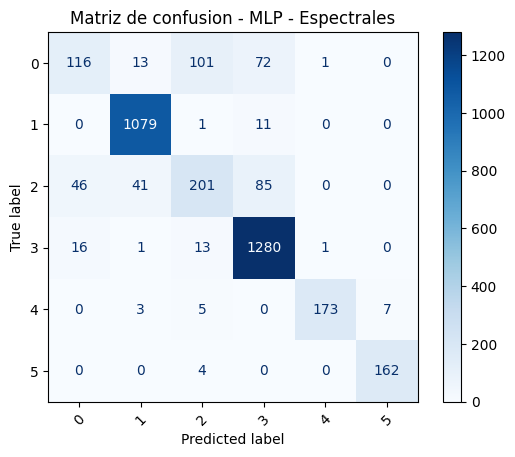

In [23]:
confusion_matrix_models(y_temp_test, y_temp_pred, "Matriz de confusion - MLP - Temporales")
confusion_matrix_models(y_spec_test, y_spec_pred, "Matriz de confusion - MLP - Espectrales")

In [24]:
ejemplos_clasificados(y_temp_test, y_temp_pred, "temporales", "MLP")
ejemplos_clasificados(y_spec_test, y_spec_pred, "espectrales", "MLP")

Ejemplos clasificados de MLP - temporales

Clasificados correctamente:


,Index,True,Pred
0,13170,1,1
1,12907,3,3
2,15729,3,3
3,8620,3,3
4,4058,5,5



Clasificados incorrectamente:


,Index,True,Pred
0,2751,2,3
1,744,3,2
2,9180,4,5
3,4351,0,2
4,7346,1,2


Ejemplos clasificados de MLP - espectrales

Clasificados correctamente:


,Index,True,Pred
0,13170,1,1
1,744,3,3
2,12907,3,3
3,15729,3,3
4,8620,3,3



Clasificados incorrectamente:


,Index,True,Pred
0,2751,2,3
1,9180,4,2
2,5377,0,2
3,4110,2,0
4,16049,2,3


### LSTM

In [25]:
lstm_temp = LSTMModel(input_size=X_temp_train.shape[1], num_classes=len(np.unique(y_temp_train))).to(device)
lstm_spec = LSTMModel(input_size=X_spec_train.shape[1], num_classes=len(np.unique(y_spec_train))).to(device)

In [26]:
lstm_temp.load_state_dict(torch.load(save_models_path+'/lstm_features_temporales.pth', map_location='cpu'))
lstm_temp.eval()

with torch.no_grad():
    # Para temporales
    X_tensor = torch.FloatTensor(X_temp_test.values).unsqueeze(1)  # (batch, 1, features)
    outputs = lstm_temp(X_tensor)
    y_temp_pred = outputs.argmax(dim=1).numpy()
    
    
lstm_spec.load_state_dict(torch.load(save_models_path+'/lstm_features_espectrales.pth', map_location='cpu'))
lstm_spec.eval()

with torch.no_grad():
    # Para espectrales
    X_tensor = torch.FloatTensor(X_spec_test.values).unsqueeze(1)
    outputs = lstm_spec(X_tensor)
    y_spec_pred = outputs.argmax(dim=1).numpy()

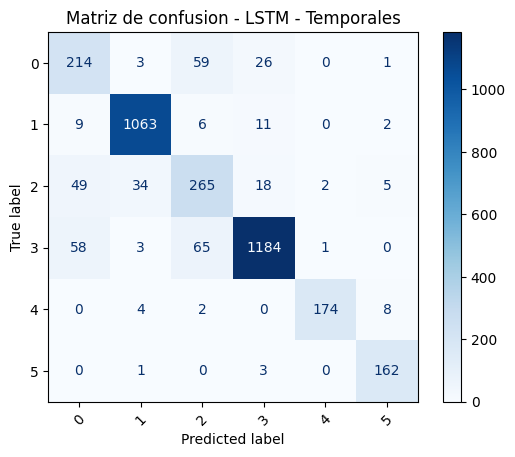

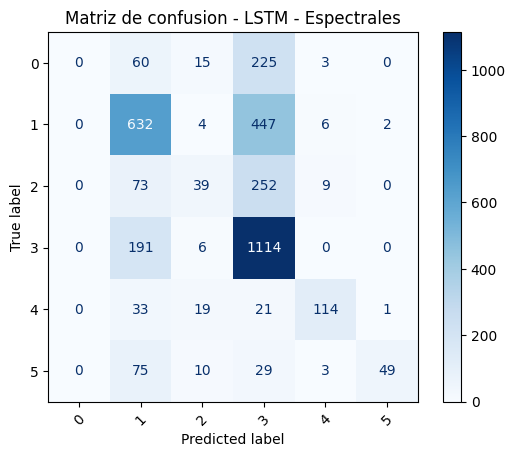

In [27]:
confusion_matrix_models(y_temp_test, y_temp_pred, "Matriz de confusion - LSTM - Temporales")
confusion_matrix_models(y_spec_test, y_spec_pred, "Matriz de confusion - LSTM - Espectrales")

In [28]:
ejemplos_clasificados(y_temp_test, y_temp_pred, "temporales", "LSTM")
ejemplos_clasificados(y_spec_test, y_spec_pred, "espectrales", "LSTM")

Ejemplos clasificados de LSTM - temporales

Clasificados correctamente:


,Index,True,Pred
0,13170,1,1
1,12907,3,3
2,15729,3,3
3,8620,3,3
4,4058,5,5



Clasificados incorrectamente:


,Index,True,Pred
0,2751,2,3
1,744,3,2
2,9180,4,5
3,7621,3,0
4,4351,0,2


Ejemplos clasificados de LSTM - espectrales

Clasificados correctamente:


,Index,True,Pred
0,13170,1,1
1,744,3,3
2,12907,3,3
3,15729,3,3
4,8620,3,3



Clasificados incorrectamente:


,Index,True,Pred
0,2751,2,3
1,4058,5,1
2,9180,4,3
3,7621,3,1
4,5377,0,3


### CNN

In [29]:
cnn_temp = CNNModel(input_channels=1, num_classes=len(np.unique(y_temp_train)), input_features=X_temp_train.shape[1]).to(device)
cnn_spec = CNNModel(input_channels=1, num_classes=len(np.unique(y_spec_train)), input_features=X_spec_train.shape[1]).to(device)

In [30]:
cnn_temp.load_state_dict(torch.load(save_models_path + '/cnn_features_temporales.pth', map_location='cpu'))
cnn_temp.eval()

with torch.no_grad():
    # Temporales
    X_tensor_temp = torch.FloatTensor(X_temp_test.values).unsqueeze(1)  # (batch, 1, features)
    outputs_temp = cnn_temp(X_tensor_temp)
    y_temp_pred = outputs_temp.argmax(dim=1).numpy()
    

cnn_spec.load_state_dict(torch.load(save_models_path + '/cnn_features_espectrales.pth', map_location='cpu'))
cnn_spec.eval()

with torch.no_grad():
    # Espectrales
    X_tensor_spec = torch.FloatTensor(X_spec_test.values).unsqueeze(1)
    outputs_spec = cnn_spec(X_tensor_spec)
    y_spec_pred = outputs_spec.argmax(dim=1).numpy()

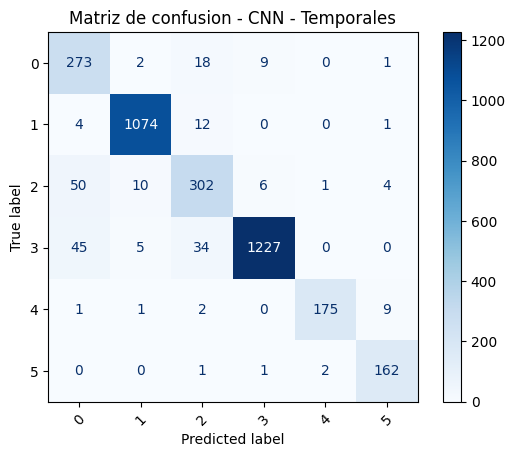

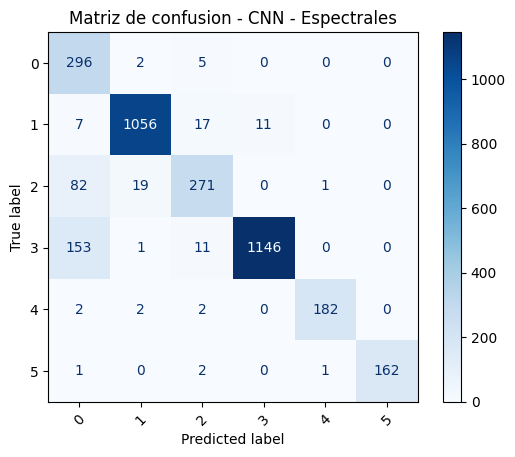

In [31]:
confusion_matrix_models(y_temp_test, y_temp_pred, "Matriz de confusion - CNN - Temporales")
confusion_matrix_models(y_spec_test, y_spec_pred, "Matriz de confusion - CNN - Espectrales")

In [32]:
ejemplos_clasificados(y_temp_test, y_temp_pred, "temporales", "CNN")
ejemplos_clasificados(y_spec_test, y_spec_pred, "espectrales", "CNN")

Ejemplos clasificados de CNN - temporales

Clasificados correctamente:


,Index,True,Pred
0,13170,1,1
1,2751,2,2
2,744,3,3
3,12907,3,3
4,15729,3,3



Clasificados incorrectamente:


,Index,True,Pred
0,9180,4,5
1,7346,1,0
2,13700,0,2
3,3678,3,0
4,13077,0,2


Ejemplos clasificados de CNN - espectrales

Clasificados correctamente:


,Index,True,Pred
0,13170,1,1
1,2751,2,2
2,744,3,3
3,12907,3,3
4,15729,3,3



Clasificados incorrectamente:


,Index,True,Pred
0,9180,4,0
1,7621,3,0
2,4110,2,0
3,7346,1,0
4,664,3,0
